Imports

In [12]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks

plt.style.use("seaborn-v0_8-whitegrid")


Load metadata and set up paths

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/human-action-recognition-har-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-action-recognition-har-dataset' dataset.
Path to dataset files: /kaggle/input/human-action-recognition-har-dataset


In [18]:
data_dir = Path(path+"/Human Action Recognition")
train_csv = data_dir / "Training_set.csv"
test_csv = data_dir / "Testing_set.csv"
train_img_dir = data_dir / "train"
test_img_dir = data_dir / "test"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
display(train_df.head())


Train rows: 12600 | Test rows: 5400
Train columns: ['filename', 'label']
Test columns: ['filename']


,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


Basic data quality checks

In [19]:
# Check for missing values and duplicates
missing = train_df.isna().sum()
duplicate_rows = train_df.duplicated().sum()

print("Missing values per column:\n", missing)
print(f"\nDuplicate rows: {duplicate_rows}")

# Label distribution across the full training set
label_counts = train_df["label"].value_counts().sort_values(ascending=False)
print("\nLabel distribution (counts):")
print(label_counts)
print("\nLabel distribution (percent):")
print((label_counts / len(train_df) * 100).round(2))


Missing values per column:
 filename    0
label       0
dtype: int64

Duplicate rows: 0

Label distribution (counts):
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

Label distribution (percent):
label
sitting               6.67
using_laptop          6.67
hugging               6.67
sleeping              6.67
drinking              6.67
clapping              6.67
dancing               6.67
cycling               6.67
calling               6.67
laughing              6.67
eating                6.67
fighting              6.67
listening_to_music    6.67
running               6.67
texting               6.67
Name: count, dtype

Add resolved file paths and validate availability

In [20]:
# Add absolute-style paths and verify the files exist on disk
train_df["filepath"] = train_df["filename"].apply(lambda x: train_img_dir / x)
test_df["filepath"] = test_df["filename"].apply(lambda x: test_img_dir / x)

missing_train_files = train_df[~train_df["filepath"].apply(Path.exists)]
missing_test_files = test_df[~test_df["filepath"].apply(Path.exists)]

print(f"Missing train images: {len(missing_train_files)}")
print(f"Missing test images: {len(missing_test_files)}")
if not missing_train_files.empty:
    display(missing_train_files.head())
if not missing_test_files.empty:
    display(missing_test_files.head())


Missing train images: 0
Missing test images: 0


Train/validation split and label encoding

In [21]:
# Encode labels and create stratified train/validation splits
label_encoder = LabelEncoder()
train_df["label_idx"] = label_encoder.fit_transform(train_df["label"])

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"],
)

print(f"Train split: {len(train_split)} rows")
print(f"Validation split: {len(val_split)} rows")
print(f"Test rows (no labels provided): {len(test_df)}")

# Show that stratification maintained the distribution
train_split_counts = train_split["label"].value_counts().sort_values(ascending=False)
val_split_counts = val_split["label"].value_counts().sort_values(ascending=False)
print("\nTrain split label distribution:")
print(train_split_counts)
print("\nValidation split label distribution:")
print(val_split_counts)

# Optional: compute simple class weights for handling imbalance later
class_weights = (len(train_split) / (len(train_split_counts) * train_split_counts)).to_dict()
print("\nSuggested class weights:")
print(class_weights)


Train split: 10080 rows
Validation split: 2520 rows
Test rows (no labels provided): 5400

Train split label distribution:
label
cycling               672
dancing               672
hugging               672
running               672
clapping              672
eating                672
laughing              672
texting               672
sitting               672
drinking              672
listening_to_music    672
calling               672
using_laptop          672
fighting              672
sleeping              672
Name: count, dtype: int64

Validation split label distribution:
label
clapping              168
sleeping              168
using_laptop          168
fighting              168
calling               168
hugging               168
sitting               168
cycling               168
drinking              168
eating                168
running               168
listening_to_music    168
dancing               168
texting               168
laughing              168
Name: count, dtype: in

Visualize label distribution

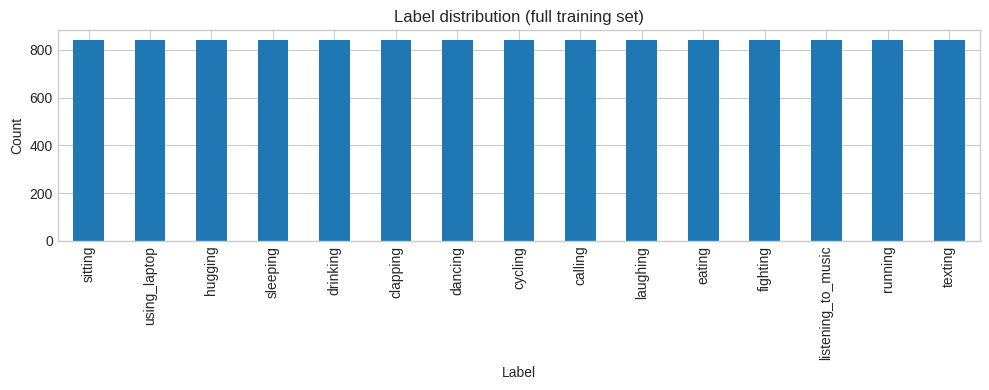

In [22]:
label_counts_full = train_df["label"].value_counts().sort_values(ascending=False)
label_counts_full.plot(kind="bar", figsize=(10, 4))
plt.title("Label distribution (full training set)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


ResNet50 Train and validation

In [24]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20  # adjust as needed

num_classes = train_df["label_idx"].nunique()

# ================================
# 3) Build tf.data pipelines
# ================================
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)  # ResNet50 preprocessing
    return img, label

# Convert filepaths and labels to tensors
train_paths = train_split["filepath"].astype(str).values
train_labels = train_split["label_idx"].values

val_paths = val_split["filepath"].astype(str).values
val_labels = val_split["label_idx"].values

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((val_paths, val_labels))
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# ================================
# 4) Define ResNet50 model
# ================================
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# Freeze base model for initial training
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

# ================================
# 5) Train (frozen backbone)
# ================================
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

checkpoint = callbacks.ModelCheckpoint(
    "resnet50_best.keras",
    monitor="val_loss",
    save_best_only=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
)

# ================================
# 6) Optional: fine-tune top layers
# ================================
# Unfreeze some of the deeper layers of ResNet50
fine_tune_at = 140  # layer index to start unfreezing from (tune if needed)
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

fine_tune_epochs = 5  # extra epochs for fine-tuning

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, checkpoint],
)

# ================================
# 7) Final validation metrics
# ================================
val_loss, val_acc = model.evaluate(val_ds)
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 78s 192ms/step - accuracy: 0.4084 - loss: 1.9757 - val_accuracy: 0.6587 - val_loss: 1.0787
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.6586 - loss: 1.0418 - val_accuracy: 0.6857 - val_loss: 1.0116
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.7041 - loss: 0.9333 - val_accuracy: 0.6833 - val_loss: 1.0098
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.7205 - loss: 0.8712 - val_accuracy: 0.6929 - val_loss: 0.9852
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.7455 - loss: 0.7999 - val_accuracy: 0.7036 - val_loss: 0.9735
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.7423 - loss: 0.7925 - val_accuracy: 0.7075 - val_loss: 0.9649
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7541 - loss: 0.7672 - val_accuracy: 0.6996 - val_loss: 0.9548
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7610 - loss: 0

## Test-time predictions
Generate predictions on the held-out test split using the saved ResNet50 model.

In [25]:
# Build inference dataset and generate predictions on the unlabeled test split
def load_and_preprocess_infer(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img

idx_to_label = {idx: cls for idx, cls in enumerate(label_encoder.classes_)}

test_paths = test_df['filepath'].astype(str).values
test_ds = (
    tf.data.Dataset.from_tensor_slices(test_paths)
    .map(load_and_preprocess_infer, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
probs = loaded_model.predict(test_ds)
pred_idx = probs.argmax(axis=1)

test_predictions = test_df.copy()
test_predictions['pred_label'] = [idx_to_label[i] for i in pred_idx]
test_predictions['pred_confidence'] = probs.max(axis=1)

display(test_predictions.head(15))
# Optional: save predictions for external use
# test_predictions[['filename', 'pred_label']].to_csv('predictions.csv', index=False)


169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 156ms/step


,filename,filepath,pred_label,pred_confidence
0,Image_1.jpg,/kaggle/input/human-action-recognition-har-dat...,hugging,0.651749
1,Image_2.jpg,/kaggle/input/human-action-recognition-har-dat...,eating,0.869915
2,Image_3.jpg,/kaggle/input/human-action-recognition-har-dat...,clapping,0.725780
3,Image_4.jpg,/kaggle/input/human-action-recognition-har-dat...,eating,0.876714
4,Image_5.jpg,/kaggle/input/human-action-recognition-har-dat...,listening_to_music,0.293984
5,Image_6.jpg,/kaggle/input/human-action-recognition-har-dat...,clapping,0.999226
6,Image_7.jpg,/kaggle/input/human-action-recognition-har-dat...,dancing,0.571948
7,Image_8.jpg,/kaggle/input/human-action-recognition-har-dat...,hugging,0.632407
8,Image_9.jpg,/kaggle/input/human-action-recognition-har-dat...,laughing,0.436996
9,Image_10.jpg,/kaggle/input/human-action-recognition-har-dat...,drinking,0.960240


In [ ]:
gen_data_dir = Path("general_data")
gen_test_img_dir = gen_data_dir
gen_test_csv = gen_data_dir / "general_test.csv"
gen_test_df = pd.read_csv(gen_test_csv)
display(gen_test_df)
gen_test_df["filepath"] = gen_test_df["filename"].apply(lambda x: gen_test_img_dir / x)


def load_and_preprocess_infer_gen(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img

gen_idx_to_label = {idx: cls for idx, cls in enumerate(label_encoder.classes_)}

gen_test_paths = gen_test_df['filepath'].astype(str).values
gen_test_ds = (
    tf.data.Dataset.from_tensor_slices(gen_test_paths)
    .map(load_and_preprocess_infer_gen, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
probs = loaded_model.predict(gen_test_ds)
pred_idx = probs.argmax(axis=1)

gen_test_predictions = gen_test_df.copy()
gen_test_predictions['pred_label'] = [idx_to_label[i] for i in pred_idx]
gen_test_predictions['pred_confidence'] = probs.max(axis=1)

display(gen_test_predictions)

## Confusion matrix
Evaluate the validation split with the best checkpoint and visualize misclassifications.

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step
Validation classification report:                     precision    recall  f1-score   support

           calling       0.57      0.77      0.65       168
          clapping       0.79      0.62      0.69       168
           cycling       0.96      0.99      0.97       168
           dancing       0.72      0.83      0.77       168
          drinking       0.68      0.74      0.71       168
            eating       0.85      0.84      0.84       168
          fighting       0.87      0.70      0.77       168
           hugging       0.60      0.83      0.70       168
          laughing       0.84      0.62      0.71       168
listening_to_music       0.55      0.74      0.63       168
           running       0.95      0.73      0.82       168
           sitting       0.56      0.67      0.61       168
          sleeping       0.94      0.71      0.81       168
           texting       0.85      0.49      0.62       168
      using_laptop     

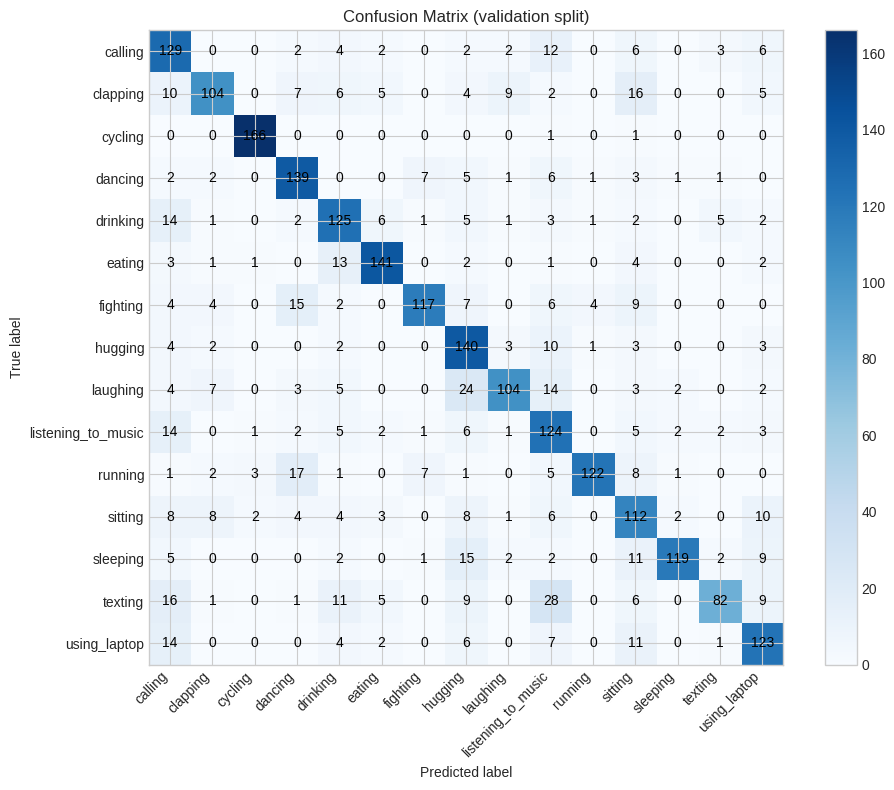

In [26]:
# Generate a confusion matrix on the validation split
num_classes = len(label_encoder.classes_)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
val_probs = loaded_model.predict(val_ds)
val_pred_idx = val_probs.argmax(axis=1)
true_labels = val_labels

cm = confusion_matrix(true_labels, val_pred_idx, labels=range(num_classes))
print('Validation classification report:', classification_report(
    true_labels, val_pred_idx, target_names=label_encoder.classes_, zero_division=0,
))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
ax.set_yticklabels(label_encoder.classes_)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix (validation split)')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()
